In [69]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from requests import get as get
from requests import post as post
import bcrypt

os.chdir("")   #Set working directory

# Collect the data

In [ ]:
#Login to get autenticated queries
email = "your@emailadres.com" #Insert your e-mail
salt_url = f"https://api.sorare.com/api/v1/users/{email}"

res = requests.get(salt_url, headers={"Content-Type": "application/json"})

salt = res.json()["salt"] 

# get salt and hash with password
pwrd = "Your Password".encode('utf-8') #Insert your password
salt_bytes = salt.encode('utf-8')
hashed = bcrypt.hashpw(pwrd, salt_bytes).decode()

URL = "https://api.sorare.com/graphql"
aud = "your_model"  # name of your app, required

#Define query
query = f"""
mutation SignInMutation($input: signInInput!) {{
  signIn(input: $input) {{
    currentUser {{
      slug
    }}
    jwtToken(aud: "{aud}") {{
      token
      expiredAt
    }}
    otpSessionChallenge
    errors {{
      message
    }}
  }}
}}
"""

#Define input
variables = {
    "input": {
        "email": email,
        "password": hashed
    }
}

#First log in attempt
response = requests.post(URL, json={"query": query, "variables": variables}, headers={"Content-Type": "application/json"})
data_firstcall = json.loads(response.content.decode('utf-8'))
otp_code = data_firstcall['data']['signIn']['otpSessionChallenge']

#Give 2FA
otp = {
  "input": {
    "otpSessionChallenge": otp_code,
    "otpAttempt": "your_2fa_code"  #Insert your 2FA code
  }
}
#Get token
p = post(URL, json={'query': query, 'OperationName': 'SignInMutation', 'variables': otp})
data_secondcall = json.loads(p.content.decode('utf-8'))
token = data_secondcall['data']['signIn']['jwtToken']['token']

#create function
#def run_query(uri, query, statusCode, headers):
def run_query(uri, query, statusCode, header):
    request = requests.post(uri, json={'query': query}, headers=header)
    if request.status_code == statusCode:
        return request.json()
    else:
        raise Exception(f"Unexpected status code returned: {request.status_code}")
        
StatusCode = 200

#Define final header
headers = {
        "Authorization": f"Bearer {token}",
        "JWT-AUD": aud,
        "Content-Type": "application/json" 
    }


In [ ]:
#define the leagues we want to include in our analysis
def sorare_games_info(comp):
    #Make list to save the retrieved data
    club_data = []
    
    #Get for every league the data
    result_league = run_query(URL, leagues(comp), StatusCode, headers)
    
        #If the query is able to receive our data, save it in the list
    if result_league.get("data") and result_league["data"]["football"]["competition"]:
        for club in result_league["data"]["football"]["competition"]["contestants"]:
            club_data.append({"teamname": club["team"]["slug"]})
    else:
        print(f"No data returned for league: {comp}")
        return None, None
        
    # Create final DataFrame
    club_names = pd.DataFrame(club_data).reset_index(drop=True)
    
    #Define dataframes
    player_names = pd.DataFrame()
    games_pd = pd.DataFrame()
    
    #loop through all the clubs
    for index, row in club_names.iterrows():
        try:
            #First get list of players
            result_club = run_query(URL, activeplayers(row['teamname']), StatusCode, headers)
            #Save results in list
            names =[] 
            #team_name = result_club['data']['football']['club']['name']
            for player in result_club['data']['football']['club']['activePlayers']['nodes']:
                slug = player['slug'] 
                age = player['age'] 
                height = player['height'] 
                position = player['position']
                #team_name = row['teamname']
                item = {
                    "slug": slug,
                    "age": age,        
                    "height": height,
                    "position": position
                }
                
                names.append(item) 
        except Exception as e:
            print(f"Error fetching players for {row['teamname']}: {e}")
            continue

        players=pd.DataFrame(names)
        #remove the coach
        players = players[~(players["position"]=="Coach")]

        #Concat all information
        player_names = pd.concat([player_names, players], ignore_index=True)
        
        #Then get dates of games played by the player
        for index, name in players.iterrows():
            player_name = name['slug']
            scores = get_all_so5_scores(name['slug'], max_scores=100)
    
            # adding a time delay. To reduce chance of hitting the Request limit
            time.sleep(15)
            games =[] 
            #loop through the scores and save them
            for game in scores:
                date = game['game']['date']
                competition= game['game']['competition']['name']
                minsPlayed = game['playerGameStats']['minsPlayed'] 
                team_name = game['playerGameStats']['anyTeam']['officialName']
                decisive = game['playerGameStats']['so5Score']['decisiveScore']['totalScore']
                score = game['score'] 
                item = {
                    "Date": date,
                    "so5score": score,
                    "competition": competition,
                    "minsPlayed": minsPlayed,
                    "slug": player_name,
                    "decisive": decisive,
                    "teamname": team_name
                    }
                games.append(item)  
            #Add the outcomes to the dataframe
            games_pd = pd.concat([games_pd, pd.DataFrame(games)], ignore_index=True)

    #give the data back 
    return games_pd, player_names

# Clean and structure data

In [76]:
# Combine datasets
pl= pd.merge(pl_games, pl_players, how="left", on=["slug"])

#transform Date into datetime
pl['Date'] = pd.to_datetime(pl['Date']).dt.date
    
#Only include observations where the individual played more than 60 minutes
pl = pl[(pl["minsPlayed"]>60)]

#Calculate AA score
pl['AA'] = pl['so5score']-pl['decisive']

#Only scores from 2024 and 2025
pl = pl[pd.to_datetime(pl['Date']).dt.year.isin([2024, 2025])]

#estimate average score per position per game
pl['AVG_score'] = pl.groupby(['position', 'Date', 'teamname'])['so5score'].transform('mean')
pl['AVG_AA'] = pl.groupby(['position', 'Date', 'teamname'])['AA'].transform('mean')

#European matches could also be part of the dataset, thus filter on competition
pl = pl[pl['competition']=="Premier League"]

#Keep only the columns we need for the general position correlation
pl = pl[['position', 'Date', 'AVG_score', 'teamname', 'AVG_AA']]

#Reshape the table to wide
pl_wide = pl.pivot_table(index=['teamname', 'Date'], columns='position', values=['AVG_score', 'AVG_AA']).reset_index()

#Rename columns, remove the double header
pl_wide.columns = [
    f"{col2}_{col1}" if col1 != '' else col2
    for col1, col2 in pl_wide.columns
]

# Estimate correlations

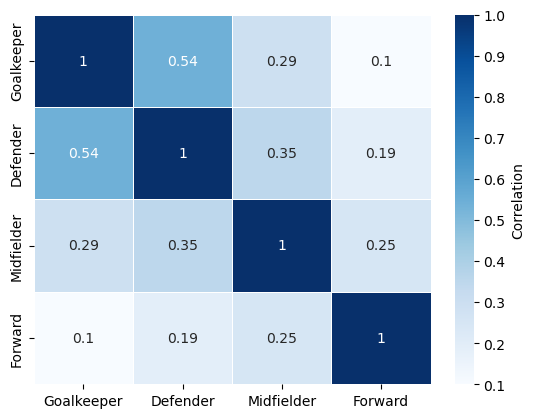

In [119]:
#Keep columns of the positions
p = pl_wide[['Goalkeeper_AVG_score', 'Defender_AVG_score', 'Midfielder_AVG_score', 'Forward_AVG_score']]
#create correlation matrix, with 2 decimals.
p_corr_matrix = p.corr().round(2)
#create correlation plot
sns.heatmap(
    p_corr_matrix,
    cmap="Blues",             
    annot=True,                 
    linewidths=0.5,              
    xticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    yticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    cbar_kws={'label': 'Correlation'},  
)
plt.savefig("./PL_corr.png", dpi=300, bbox_inches='tight')


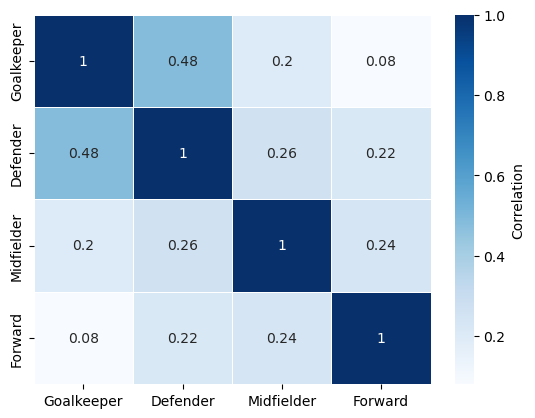

In [117]:
#Select the topteams in Premier League
pl_top = pl_wide[pl_wide['_teamname'].isin(['Liverpool FC', 'Arsenal FC', 'Manchester City FC'])]
#Keep columns of the positions
p_top = pl_top[['Goalkeeper_AVG_score', 'Defender_AVG_score', 'Midfielder_AVG_score', 'Forward_AVG_score']]
#create correlation matrix, with 2 decimals.
p_top_corr_matrix = p_top.corr().round(2)
#create correlation plot
sns.heatmap(
    p_top_corr_matrix,
    cmap="Blues",              # Change color scheme (e.g., "viridis", "magma", "YlGnBu", etc.)
    annot=True,                 
    linewidths=0.5,              
    xticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    yticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    cbar_kws={'label': 'Correlation'},  
)
plt.savefig("./topteams_PL.png", dpi=300, bbox_inches='tight')


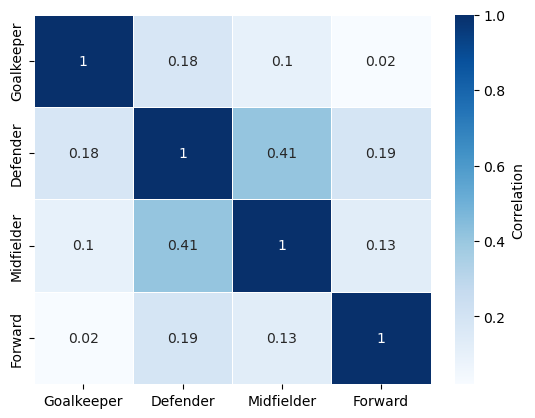

In [121]:
#What about AA?
p_aa = pl_wide[['Goalkeeper_AVG_AA', 'Defender_AVG_AA', 'Midfielder_AVG_AA', 'Forward_AVG_AA']]
#create correlation matrix, with 2 decimals.
p_aa_corr_matrix = p_aa.corr().round(2)
#create correlation plot
sns.heatmap(
    p_aa_corr_matrix,
    cmap="Blues",              # Change color scheme (e.g., "viridis", "magma", "YlGnBu", etc.)
    annot=True,                 
    linewidths=0.5,              
    xticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    yticklabels=['Goalkeeper', 'Defender', 'Midfielder', 'Forward'],
    cbar_kws={'label': 'Correlation'},  
)
plt.savefig("./AA_PL.png", dpi=300, bbox_inches='tight')
